In [2]:
## Include packages

using DelimitedFiles
using DCAUtils
using Statistics
using KitMSA
using FastaIO
using LinearAlgebra
using StatsBase
using PyPlot

include("../src/read_write.jl")
include("../src/energy.jl")
include("../src/msa_tools.jl")
include("../src/extra_tools.jl")
;

In [3]:
PATH_PAR_dbd = "../data/model_parameters/Parameters_conv_Thr-PCD40.dat"
htmp, Jtmp = KitMSA.read_par_BM(PATH_PAR_dbd)
h = KitMSA.set_max_field_to_0(htmp)
J = KitMSA.symmetrize_J(Jtmp)
maximum(J)
;

In [4]:
function compare_seq(a::Array{Int8,1}, b::Array{Int8,1})
    if a == b
        return 0
    else
        return findall(a .!= b)[1]
    end
end

function find_positions(msa)
    
    return [compare_seq(msa[j-1,:], msa[j,:]) for j in 2:length(msa[:,1])]
        
end



function get_entropy(f; q =21)
    N=length(f[1,:])
    entr = zeros(Float64, N)
    for i in 1:N
        for a in 1:q
            if(f[a,i]>0)
                entr[i]-=f[a,i]*log(f[a,i])
            end
        end
    end
    
    return entr / log(2)
end

function proba_DNA_gibbs_without_deg(k, mutated_seq, h, J, N; q = 21, T = 1)
	prob = zeros(q)
	for i in 1:q
        q_k = i
		log_proba = h[q_k, k]
 		for j in 1:N
			log_proba += J[mutated_seq[j], q_k , j, k]
        end
		prob[i] = exp(log_proba/T)
	end
	return normalize(prob,1)
    
end

function cont_dep_entr_without_deg(background, h, J; q =21, T =1)
    
    N = length(background)
    
    prob = hcat([ProbabilityWeights(proba_DNA_gibbs_without_deg(pos_mut, background, h, J, N, T=T, q=q)) for pos_mut in 1:N]...)

    return get_entropy(prob, q = q)[:]
end

function write_cde_of_chains(folder, out_path, mask, h, J, n)
    fasta_files = filter(file -> endswith(file, ".mixedDNA"), readdir(folder))
    res = []
    for i in 1:n
        chain = Int8.(fasta2matrix(joinpath(folder_path, fasta_files[i])))[mask,:]
        cde_msa = hcat([cont_dep_entr_without_deg(chain[step,:], h, J, q= 21) 
                for step in 1:length(chain[:,1])]...)'
        push!(res, vec(cde_msa))
        if i %10 == 0
            println(i)
        end
    end
    writedlm(out_path, hcat(res...))
    return hcat(res...)
end

function cde_1site(site, background, h, J; q = 21,  T = 1)
  
    N = length(background)
    prob = ProbabilityWeights(proba_DNA_gibbs_without_deg(site, 
            background, h, J, N, T = T, q = q))
    return get_entropy(prob, q = q)
end


function cde_chain(chain, h, J)
    
    res = zeros(size(chain))
    
    res[1,:] = cont_dep_entr_without_deg(chain[1,:], h, J, q= 21)[:] 
    
    for i in 2:size(chain, 1)
        if matrices[i,:] == matrices
            res[i,:] = res[i-1, :]
        else 
            res[i,:] = cont_dep_entr_without_deg(chain[i,:], h, J, q= 21)[:]
        end
    end
    
    return res
end

cde_chain (generic function with 1 method)

In [5]:
path_wt_pse = "../data/alignments/refs/PSE1_pfam_DNA.fasta"

#load wt
wt_pse = join(readdlm(path_wt_pse, skipstart = 1))
L_pse = Int64(length(wt_pse)/3)
pse_DNA_seq = [wt_pse[((i-1)*3 +1):(i*3)] for i in 1:L_pse]
pse_amino_seq = [cod2amino[codon] for codon in pse_DNA_seq]
path_beta = "../data/alignments/natural/PF13354_noinsert_max19gaps_nodupl_noclose.faa"
nat_beta = Int8.(fasta2matrix(path_beta))
path_dbd = "../data/alignments/natural/DBD_alignment.uniref90.cov80.a2m"
nat_dbd = Int8.(fasta2matrix(path_dbd))
w_dbd = DCAUtils.compute_weights(Int8.(nat_dbd'), 0.2)[1]
;

θ = 0.2 threshold = 15.0
M = 24944 N = 76 Meff = 3129.1468140631705


In [6]:
folder_path2 = "../../scra_data_beta/amino_mixed_dbd_steps5000000_seqs2_T1.0p0.5/equil_det_bal_dbd_silico_chain_num_1_T_1.0.mixedDNA"
@time matrices = Int8.(fasta2matrix(folder_path2))[1:50001, :]
@time pos = find_positions(matrices)
mut_times = [i for (i, val) in enumerate(pos) if val != 0]
mut_sites = [val for val in pos if val != 0]
mut_ab = [sum(mut_sites .== i) ./length(mut_sites) for i in 1:size(matrices,2)]
;

 14.484489 seconds (30.03 M allocations: 3.755 GiB, 6.42% gc time, 0.31% compilation time)
  0.182646 seconds (362.19 k allocations: 29.535 MiB, 89.46% compilation time)


In [7]:
folder_path2 = "../../scra_data_beta/seqs_ev_wtThornton_100000steps_100000stored"

function read_sequences(filename::AbstractString)
    sequences = Vector{Vector{Char}}()  # Vector of Vector{Char}
    
    # Open the file
    open(filename) do file
        for line in eachline(file)
            # Check if the line contains a sequence
            if !startswith(line, "step") && !isempty(strip(line))
                push!(sequences, collect(line))
            end
        end
    end
    
    return sequences
end

# Usage example
sequences = read_sequences(folder_path2)

matrices = Int8.(hcat([Int8.(letter2num.(seq)) for seq in sequences]...)')
@time pos = find_positions(matrices)
mut_times = [i for (i, val) in enumerate(pos) if val != 0]
mut_sites = [val for val in pos if val != 0]
mut_ab = [sum(mut_sites .== i) ./length(mut_sites) for i in 1:size(matrices,2)];
;

  0.046130 seconds (254.48 k allocations: 28.320 MiB)


In [8]:
L = 76
@time freqs_nat = reshape(compute_weighted_frequencies(Int8.(nat_dbd'), 0.2)[1], (20, L))
gap_f = 1 .- [sum(freqs_nat[:,i]) for i in 1:76]
freqs_nat_gap = rand(21,76)
freqs_nat_gap[1:20,:] = freqs_nat
freqs_nat_gap[21,:] = gap_f
entr_nat = get_entropy(freqs_nat_gap) 
;

θ = 0.2 threshold = 15.0
M = 24944 N = 76 Meff = 3129.1468140631705
  4.888275 seconds (149.97 k allocations: 59.147 MiB, 3.51% compilation time)


In [8]:
find_ones(arr) = [i for (i, val) in enumerate(arr) if val == 1]

find_ones (generic function with 1 method)

## First analysis

In [300]:
cde_mut = []
cie_mut = []
for i in 1:length(mut_sites)
    push!(cie_mut, entr_nat[mut_sites[i]])
    push!(cde_mut, cde_1site(mut_sites[i], matrices[mut_times[i],:], h, J, q = 21)[1] / log(2))
end


In [301]:
cde_t = cde_chain(matrices, h, J) ./log(2);

In [302]:
ep = findmax(entr_nat .- cde_t[1,:])[2]
var = findmax(entr_nat)[2]
cons = findmin(entr_nat)[2]
cas = 60

60

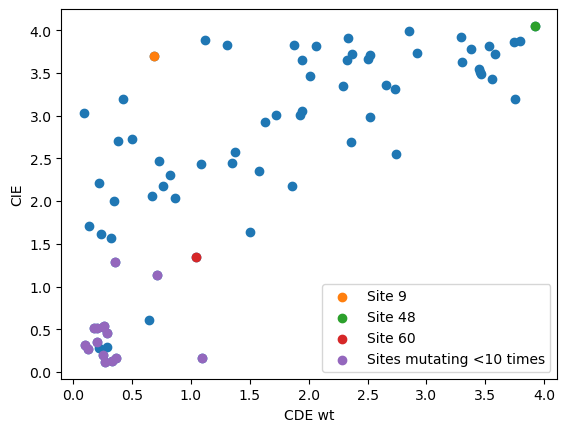

In [286]:
plt.scatter(cde_t[1,:], entr_nat)
plt.scatter(cde_t[1, ep], entr_nat[ep], label ="Site $(ep)")
plt.scatter(cde_t[1, var], entr_nat[var],  label ="Site $(var)")
plt.scatter(cde_t[1, cas], entr_nat[cas],  label ="Site $(cas)")
plt.scatter(cde_t[1, mut_ab .< 0.002], entr_nat[mut_ab .< 0.002],  label ="Sites mutating <10 times")
plt.xlabel("CDE wt")
plt.ylabel("CIE")
plt.legend()
savefig("../start.png")

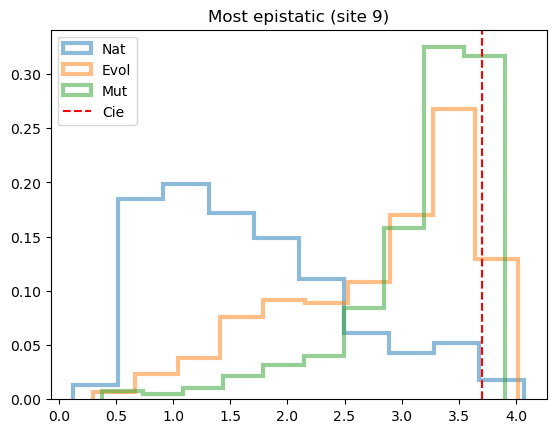

In [303]:
site = ep
plt.hist(cde_nat[:,site], alpha = 0.5, weights = ones(size(cde_nat[:,site])) ./ size(cde_nat[:,site]), histtype= "step", linewidth = 3, label = "Nat")
plt.hist(cde_t[:,site], alpha = 0.5,  weights = ones(size(cde_t[:,site])) ./ size(cde_t[:,site]),  histtype= "step", linewidth = 3, label = "Evol")
plt.hist(cde_mut[mut_sites .== site], alpha = 0.5, weights = ones(size(cde_mut[mut_sites .== site])) ./ size(cde_mut[mut_sites .== site]),  histtype= "step", linewidth = 3, label = "Mut")
plt.axvline(x=entr_nat[site], linestyle = "--", color = "red", label = "Cie")
plt.title("Most epistatic (site $(ep))")
plt.legend()
savefig("../ep.png")

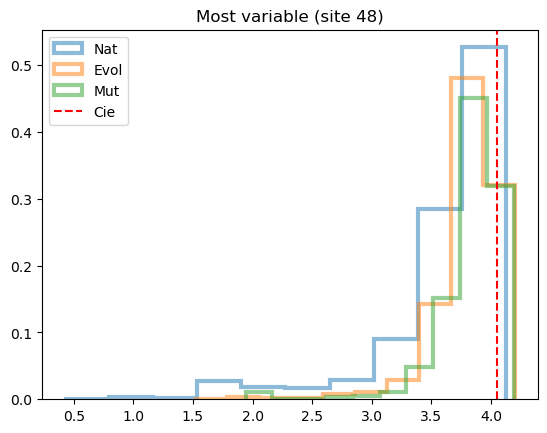

In [304]:
site = var
plt.hist(cde_nat[:,site], alpha = 0.5, weights = ones(size(cde_nat[:,site])) ./ size(cde_nat[:,site]), histtype= "step", linewidth = 3, label = "Nat")
plt.hist(cde_t[:,site], alpha = 0.5,  weights = ones(size(cde_t[:,site])) ./ size(cde_t[:,site]),  histtype= "step", linewidth = 3, label = "Evol")
plt.hist(cde_mut[mut_sites .== site], alpha = 0.5, weights = ones(size(cde_mut[mut_sites .== site])) ./ size(cde_mut[mut_sites .== site]),  histtype= "step", linewidth = 3, label = "Mut")
plt.axvline(x=entr_nat[site], linestyle = "--", color = "red", label = "Cie")
plt.title("Most variable (site $(var))")
plt.legend()
savefig("../var.png")

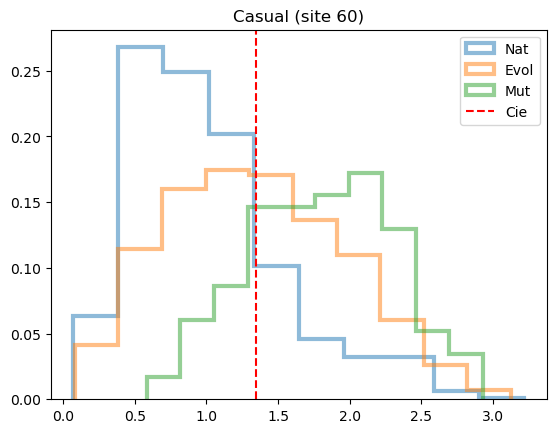

In [305]:
site = cas
plt.hist(cde_nat[:,site], alpha = 0.5, weights = ones(size(cde_nat[:,site])) ./ size(cde_nat[:,site]), histtype= "step", linewidth = 3, label = "Nat")
plt.hist(cde_t[:,site], alpha = 0.5,  weights = ones(size(cde_t[:,site])) ./ size(cde_t[:,site]),  histtype= "step", linewidth = 3, label = "Evol")
plt.hist(cde_mut[mut_sites .== site], alpha = 0.5, weights = ones(size(cde_mut[mut_sites .== site])) ./ size(cde_mut[mut_sites .== site]),  histtype= "step", linewidth = 3, label = "Mut")
plt.axvline(x=entr_nat[site], linestyle = "--", color = "red", label = "Cie")
plt.title("Casual (site $(cas))")
plt.legend()
savefig("../cas.png")

## T analysis

In [590]:
function T_cde(i, a, n, msa, w, h, J)
    res = 0
    trim_msa = msa[msa[:, n] .== a, :]
    #trim_w = w[msa[:, n] .== a]
    #_w = trim_w ./ sum(trim_w)
    
    for s in 1:size(trim_msa,1)
        cde = cde_1site(i, trim_msa[s,:], h, J)[1] / log(2)
        #res += _w[s]*(cde-2)
        res += (cde-2)
    end
    
    return res
end

T_cde (generic function with 1 method)

In [592]:
L = size(matrices,2)
q = maximum(matrices)
T_s = zeros(76, 21, 76)
start = time()
for i in 18:19
    for n in 1:L
        if n != i
            for a in 1:q
                T_s[i,a,n] = T_cde(i, a, n, nat_dbd, w, h, J) 
            end
        end
    end
end
fine = time()
println(fine-start)

18.389132976531982


In [378]:
L = size(matrices,2)
q = maximum(matrices)
T = zeros(76, 21, 76)
start = time()
for i in 1:L
    for n in 1:L
        if n != i
            for a in 1:q
                T[i,a,n] = T_cde(i, a, n, nat_dbd, w, h, J) 
            end
        end
    end
end
fine = time()
println(fine-start)

654.4022099971771


In [413]:
using JLD2

Precompiling JLD2
  ✓ FileIO
  ✓ JLD2
  2 dependencies successfully precompiled in 19 seconds. 9 already precompiled.


In [458]:
@save "../../T_saverio.jld2" T

In [544]:
TT = zeros(size(T))
for i in 1:L
    TT[i,:,:] = T[i,:,:] ./ sqrt(sum(abs2, T[i,:,:]))
end
pca = hcat([sum.(abs2, TT[i,:,:][sortperm(sum.(abs2, TT[i,:,:][:]), rev = true)]) for i in 1:76]...);
expl_var = cumsum(pca, dims = 1);

In [586]:
T0 = zeros(size(T))
for i in 1:L
    T0[i,:,:] = T[i,:,:] ./ sqrt(sum(abs2, T[i,:,:][sortperm(sum.(abs2, T[i,:,:][:]), rev = true)]))
end
pca = hcat([sum.(abs2, T0[i,:,:][sortperm(sum.(abs2, T0[i,:,:][:]), rev = true)]) for i in 1:76]...);
expl_var = cumsum(pca, dims = 1);

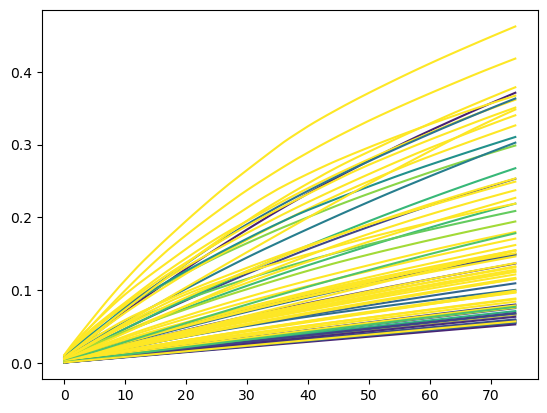

In [587]:
for i in 1:76
    plt.plot(expl_var[1:75,i] , color=PyPlot.ColorMap("viridis")(cde_t[1,i]))
end

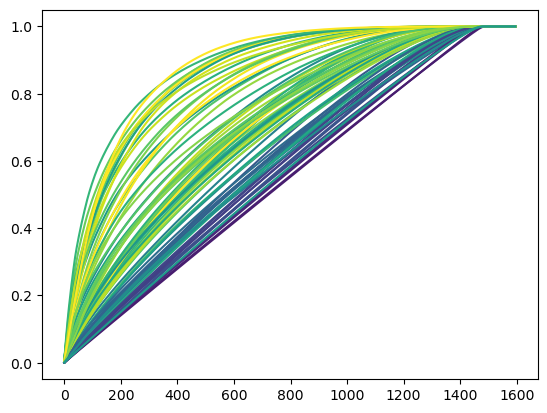

In [589]:
for i in 1:76
    plt.plot(expl_var[:,i] , color=PyPlot.ColorMap("viridis")(s_cde_nat[i]))
end


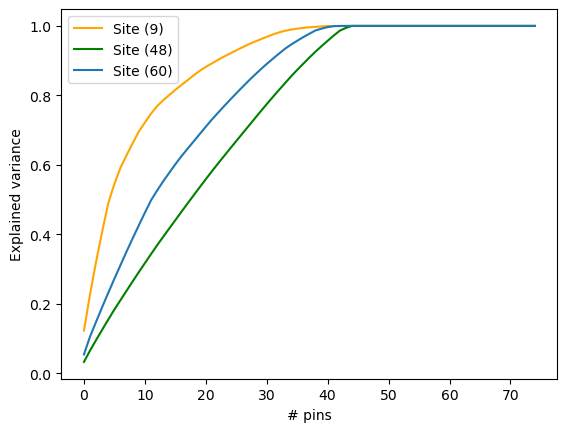

PyObject <matplotlib.legend.Legend object at 0x7f90b4279d00>

In [580]:
plt.plot(expl_var[1:75,ep] , color = "orange", label = "Site ($ep)")
plt.plot(expl_var[1:75,var] , color= "green", label = "Site ($var)")
plt.plot(expl_var[1:75,cas] , label = "Site ($cas)")
plt.xlabel("# pins")
plt.ylabel("Explained variance")
plt.legend()

## Last part

In [9]:
wt_thornton = Int8.(readdlm("../data/alignments/refs/wt_thornton")[:]);
@time cde_wt = cont_dep_entr_without_deg(wt_thornton, h, J, q = 21) ;

  0.562109 seconds (536.30 k allocations: 36.160 MiB, 98.34% compilation time)


In [10]:
function cde_DMS(wt, h, J)
    N = length(wt)
    cde = zeros(N, 21, N)
    cde_wt = cont_dep_entr_without_deg(wt, h, J, q = 21) 
    for n in 1:N
        for a in 1:21
            seq = deepcopy(wt)
            seq[n] = a
            cde[:, a , n] = (cont_dep_entr_without_deg(seq, h, J, q = 21)) .- cde_wt
        end
    end
    return cde
end
    

cde_DMS (generic function with 1 method)

In [11]:
cde_nat = zeros(size(nat_dbd))
for s in 1:size(cde_nat,1)
    cde_nat[s,:] = cont_dep_entr_without_deg(nat_dbd[s,:], h, J, q = 21) 
end

In [12]:
m_cde_nat = mean(cde_nat, weights(w_dbd), dims = 1)[:];
var_cde_nat = [var(cde_nat[:,i], weights(w_dbd)) for i in 1:76];

In [13]:
@time delta_cde = cde_DMS(wt_thornton, h, J);

  1.161206 seconds (546.61 k allocations: 95.932 MiB, 17.69% compilation time)


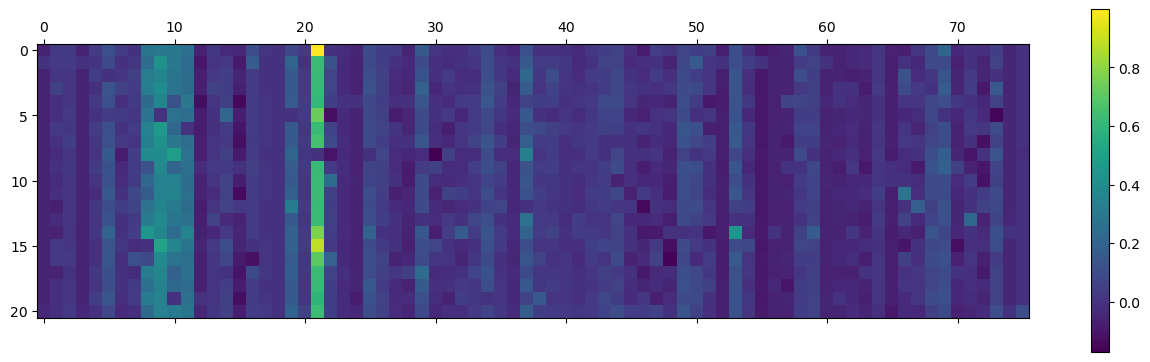

PyObject <matplotlib.colorbar.Colorbar object at 0x7f94413e0be0>

In [14]:
matshow(delta_cde[19,:,:])
colorbar()

In [15]:
argmin(entr_nat .- m_cde_nat)

56

In [16]:
function Ttable(Z::Array{Int8,2}, mean_cde_nat::Array{Float64,1},
        h::Array{Float64,2},J::Array{Float64,4}, W::Array{Float64,1})
    N, L = size(Z)
    T = zeros(Float64,L,L,21)
    for site in 1:L
        for s in 1:N
            CDE_mysite = cde_1site(site, Z[s,:], h, J, q = 21)[1] 
            for n in 1:L
                if n != site
                    T[site,n,Z[s,n]] += (CDE_mysite - mean_cde_nat[site]) * W[s]
                end
            end
        end
        T[site,:,:] ./= sum(W)
    end
    return T
end

function Ttable(site::Int, Z::Array{Int8,2}, mean_cde_nat::Array{Float64,1},
        h::Array{Float64,2},J::Array{Float64,4}, W::Array{Float64,1})
    N, L = size(Z)
    T = zeros(Float64,L,21)
    
    for s in 1:N
        CDE_mysite = cde_1site(site, Z[s,:], h, J, q = 21)[1] 
        for n in 1:L
            if n != site
                T[n,Z[s,n]] += (CDE_mysite - mean_cde_nat[site]) * W[s]
            end
        end
    end
    T[:,:] ./= sum(W)
    
    return T
end

Ttable (generic function with 2 methods)

In [17]:
tt = Ttable(nat_dbd, m_cde_nat, h, J, w_dbd);

In [27]:

#multi_tt = []
links = zeros(Int, (76, 76))
for site in 1:76
    links[site,1] = site
    println(site)
    T_single = Ttable(site, nat_dbd, m_cde_nat, h, J, w_dbd)
    inter = argmax(abs.(T_single))
    nat_red = nat_dbd[nat_dbd[:,inter[1]] .== inter[2],:]
    links[site,2] = inter[1]
    #push!(multi_tt, T_single)
    for t in 3:76
        #println(size(nat_red,1))
        T_single = Ttable(site, nat_red, m_cde_nat, h, J, w_dbd)
        inter = argmax(abs.(T_single))
        while inter[1] in links[site,:]
            T_single[inter[1], inter[2]] = 0
            inter = argmax(abs.(T_single))
            #println("cannot repeat sites")
            #println((inter[1], inter[2]))
        end 
        nat_red = nat_red[nat_red[:,inter[1]] .== inter[2],:]
        #push!(multi_tt, T_single)
        links[site,t] = inter[1]
        #println("pushed")
    end
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76


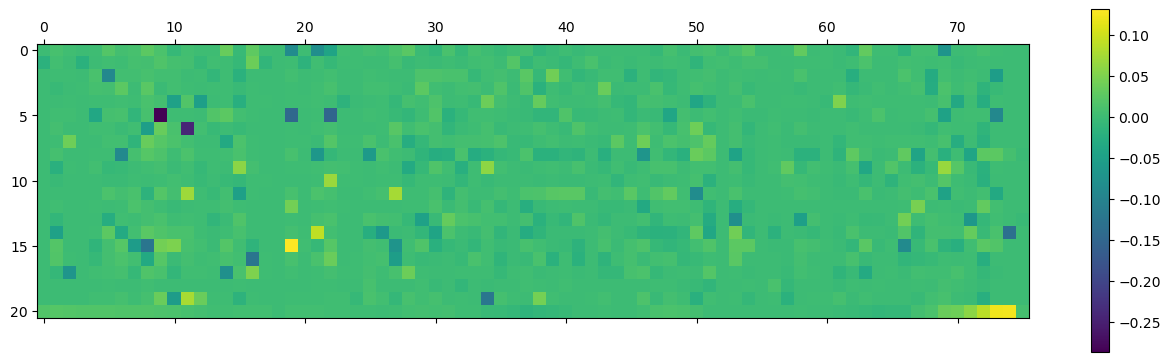

PyObject <matplotlib.colorbar.Colorbar object at 0x7f94405d0430>

In [19]:
matshow(tt[19,:,:]')
colorbar()
#savefig("../sito19.png")

In [20]:
function proba_DNA_gibbs_masked(k, sites, masked_seq, h, J; q = 21, T = 1)
	prob = zeros(q)
	for i in 1:q
        q_k = i
		log_proba = h[q_k, k]
        n = 0
 		for j in sites
            n += 1
            log_proba += J[masked_seq[n], q_k , j, k]
        end
		prob[i] = exp(log_proba/T)
	end
	return normalize(prob,1)
    
end

function proba_DNA_gibbs_field(k, h, J; q = 21, T = 1)
	prob = zeros(q)
	for i in 1:q
        q_k = i
		log_proba = h[q_k, k]
		prob[i] = exp(log_proba/T)
	end
	return normalize(prob,1)
    
end

function cde_field(pos_mut, h, J; q =21, T =1)
     
    prob = ProbabilityWeights(proba_DNA_gibbs_field(pos_mut, h, J, T=T, q=q)) 

    return get_entropy(prob, q = q)[:]
end

function cde_masked(sites, masked_seq, h, J; q =21, T =1)
    
    prob = hcat([ProbabilityWeights(proba_DNA_gibbs_masked(pos_mut, sites, masked_seq, h, J, T=T, q=q)) for pos_mut in 1:N]...)

    return get_entropy(prob, q = q)[:]
end

function cde_masked(pos_mut, sites, masked_seq, h, J; q =21, T =1)

    prob = ProbabilityWeights(proba_DNA_gibbs_masked(pos_mut, sites, masked_seq, h, J, T=T, q=q))
    
    return get_entropy(prob, q = q)[:]
end


cde_masked (generic function with 2 methods)

In [21]:
epist_ord = sortperm(abs.(entr_nat .- m_cde_nat), rev = true);
epist_score = abs.(entr_nat .- m_cde_nat)
FN = Array{Float64}(undef,L,L)
for i in 1:L
    for j in 1:L
        FN[i,j] = norm(J[:,:,i,j], 2)
    end
end

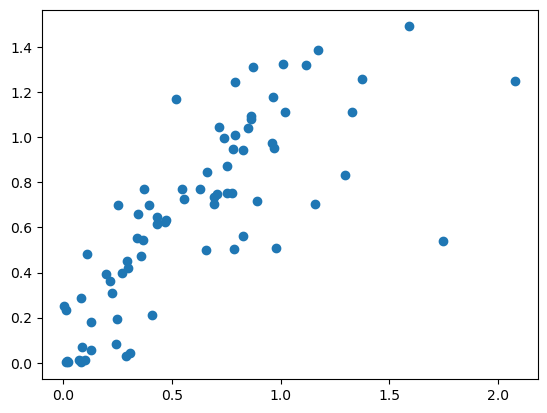

0.7822567236291438

In [754]:
scatter(var_cde_nat, epist_score)
cor(var_cde_nat, epist_score)

0.31210994720458984


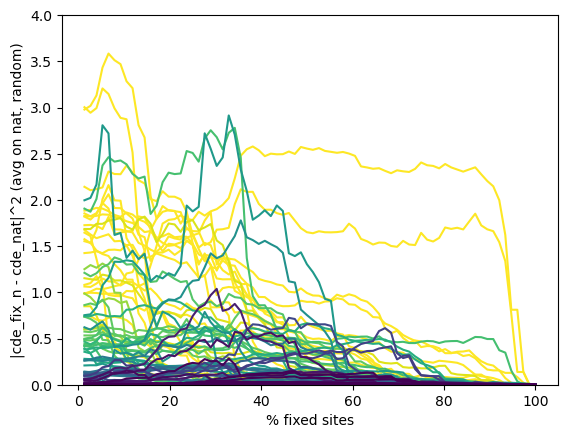

In [564]:
y = zeros(76, 76)
start = time()
for site in 1:76
    start = time()
    #real_contr = [tt[site, i, mask_seq[i]] for i in 1:size(tt,2)]
    contr = [maximum(abs.(tt[site,i,:])) for i in 1:size(tt,2)]
    #mask_seq = Int8.([argmax(abs.(tt[site,i,:])) for i in 1:size(tt,2)])
    mask_sites = [i for i in 1:76];

    ord = sortperm(contr, rev = true)

    N_seq = 1000
    cde_incr = zeros(N_seq, 76)
    for s in 1:N_seq
        cde_incr[s,:] = w_dbd[s] .* ([cde_masked(site, mask_sites[1:i], nat_dbd[s,1:i], h, J)[1] 
            for i in 1:76] .- cde_nat[s, site]) ./ sum(w_dbd[1:N_seq])
    end
    y[site,:] = sum(cde_incr, dims = 1)[:] 
end

fine = time()
println(fine-start)

for i in 1:76
    plt.plot([i for i in 1:76] .* 100 ./ 76, y[epist_ord[i], :] .^2, color=PyPlot.ColorMap("viridis")(abs.(entr_nat[epist_ord[i]] - m_cde_nat[epist_ord[i]])))
end

plt.ylim(0,4.)
plt.xlabel("% fixed sites")
plt.ylabel("|cde_fix_n - cde_nat|^2 (avg on nat, random)") 
savefig("../fig_cde_random.png")


In [47]:
argmax(entr_nat)

48

0.39812493324279785


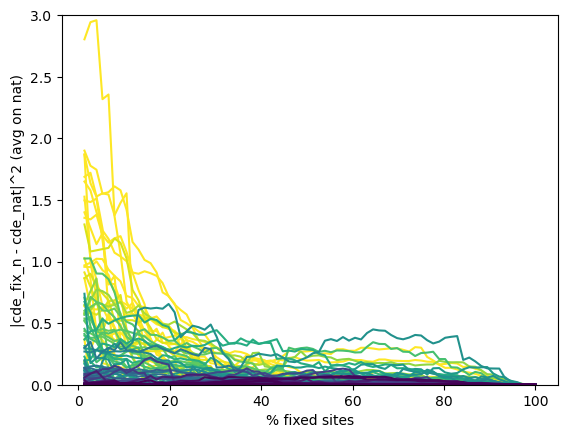

In [747]:
y = zeros(76, 76)
start = time()
for site in 1:76
    start = time()
    contr = [maximum(abs.(tt[site,i,:])) for i in 1:size(tt,2)]
    ord = sortperm(contr, rev = true)
    N_seq = 1000
    cde_incr = zeros(N_seq, 76)
    for s in 1:N_seq
        cde_incr[s,:] = w_dbd[s] .* ([cde_masked(site, ord[1:i], nat_dbd[s,:][ord[1:i]], h, J)[1] 
            for i in 1:76] .- cde_nat[s, site]) ./ sum(w_dbd[1:N_seq])
    end
    y[site,:] = sum(cde_incr, dims = 1)[:] 
end

fine = time()
println(fine-start)

for i in 1:76
    plt.plot([i for i in 1:76] .* 100 ./ 76, y[epist_ord[i], :] .^2, 
        color=PyPlot.ColorMap("viridis")(abs.(entr_nat[epist_ord[i]] - m_cde_nat[epist_ord[i]])))
end

plt.ylim(0,3.)
plt.xlabel("% fixed sites")
plt.ylabel("|cde_fix_n - cde_nat|^2 (avg on nat)") 
savefig("../fig_cde.png")

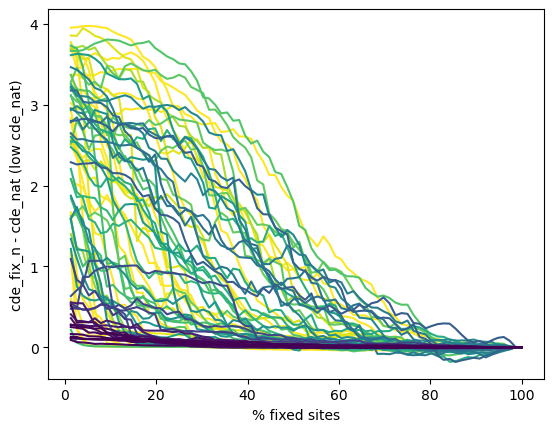

In [566]:
sites = [i for i in 1:76]
cde_incr = zeros(76, 76)
for site in sites
    seq_nat = argmin(cde_nat[:,site])
    #real_contr = [tt[site, i, mask_seq[i]] for i in 1:size(tt,2)]
    contr = [maximum(abs.(tt[site,i,:])) for i in 1:size(tt,2)]
    #mask_seq = Int8.([argmax(abs.(tt[site,i,:])) for i in 1:size(tt,2)])
    mask_sites = [i for i in 1:76];
    ord = sortperm(contr, rev = true)
    
    cde_incr[site,:] = ([cde_masked(site, mask_sites[ord][1:i], nat_dbd[seq_nat,:][mask_sites[ord][1:i]], h, J)[1] 
            for i in 1:76] .- cde_nat[seq_nat, site]);
end


for i in 1:76
    plt.plot([i for i in 1:76] .* 100 ./ 76, cde_incr[epist_ord[i], :], color=PyPlot.ColorMap("viridis")(abs.(entr_nat[epist_ord[i]] - m_cde_nat[epist_ord[i]])))
end

plt.xlabel("% fixed sites")
plt.ylabel("cde_fix_n - cde_nat (low cde_nat)") 

savefig("../fig_cde_allsites_low.png")

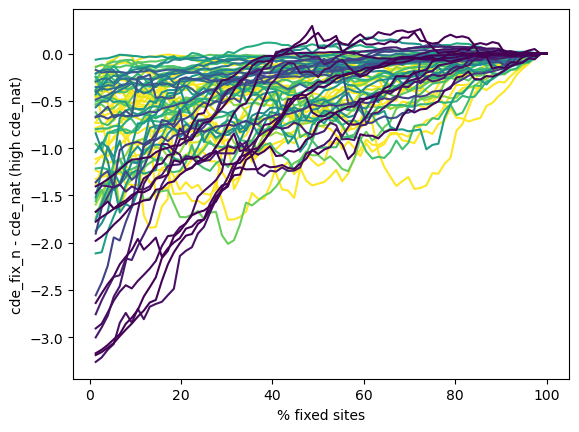

In [567]:
sites = [i for i in 1:76]
cde_incr = zeros(76, 76)
for site in sites
    seq_nat = argmax(cde_nat[:,site])
    #real_contr = [tt[site, i, mask_seq[i]] for i in 1:size(tt,2)]
    contr = [maximum(abs.(tt[site,i,:])) for i in 1:size(tt,2)]
    #mask_seq = Int8.([argmax(abs.(tt[site,i,:])) for i in 1:size(tt,2)])
    mask_sites = [i for i in 1:76];
    ord = sortperm(contr, rev = true)
    
    cde_incr[site,:] = ([cde_masked(site, mask_sites[ord][1:i], nat_dbd[seq_nat,:][mask_sites[ord][1:i]], h, J)[1] 
            for i in 1:76] .- cde_nat[seq_nat, site]);
end


for i in 1:76
    plt.plot([i for i in 1:76] .* 100 ./ 76, cde_incr[epist_ord[i], :], color=PyPlot.ColorMap("viridis")(abs.(entr_nat[epist_ord[i]] - m_cde_nat[epist_ord[i]])))
end

plt.xlabel("% fixed sites")
plt.ylabel("cde_fix_n - cde_nat (high cde_nat)") 
savefig("../fig_cde_allsites_high.png")


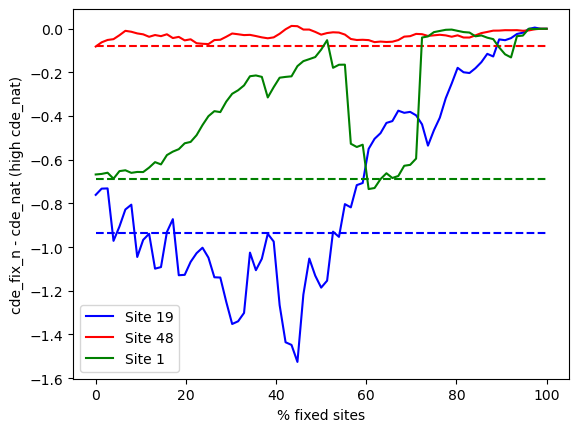

In [42]:
sites = [19,48,1]
c = ["blue", "red", "green"]
cde_incr = zeros(76, 77)
idx = 1
for site in sites
    seq_nat = argmax(cde_nat[:,site])
    #real_contr = [tt[site, i, mask_seq[i]] for i in 1:size(tt,2)]
    contr = [maximum(abs.(tt[site,i,:])) for i in 1:size(tt,2)]
    #mask_seq = Int8.([argmax(abs.(tt[site,i,:])) for i in 1:size(tt,2)])
    mask_sites = [i for i in 1:76];
    ord = sortperm(contr, rev = true)
    cde_incr[site,1] = cde_field(site, h,J)[1]  - cde_nat[seq_nat, site]  
    cde_incr[site,2:end] = ([cde_masked(site, mask_sites[ord][1:i], nat_dbd[seq_nat,:][mask_sites[ord][1:i]], h, J)[1] 
            for i in 1:76] .- cde_nat[seq_nat, site]);
    plt.plot([i for i in 0:76] .* 100 ./ 76, cde_incr[site,:], label = "Site $(site)", color = c[idx])
    plt.plot([0,100], [entr_nat[site] .- cde_nat[argmax(cde_nat[:,site]),site] for _ in 1:2],linestyle = "--", color = c[idx])
    idx += 1 
end

plt.xlabel("% fixed sites")
plt.ylabel("cde_fix_n - cde_nat (high cde_nat)") 
plt.legend()
savefig("../fig_cde_3sites_high.png")

In [572]:
cde_f = [cde_field(i, h, J)[1] for i in 1:76] 
maximum(cde_f .- entr_nat)


0.2979491674929893

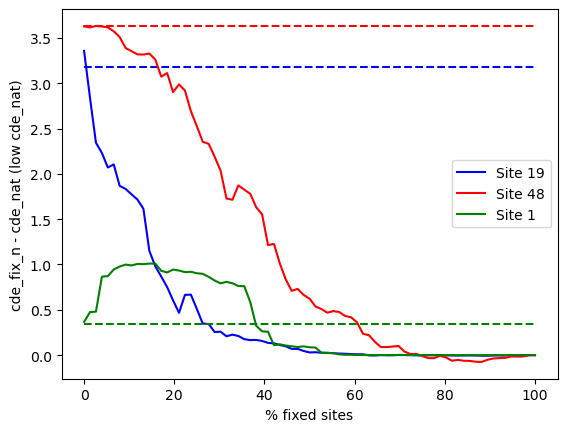

In [43]:
sites = [19, 48,1]
c = ["blue", "red", "green"]
cde_incr = zeros(76, 77)
idx = 1
for site in sites
    seq_nat = argmin(cde_nat[:,site])
    #real_contr = [tt[site, i, mask_seq[i]] for i in 1:size(tt,2)]
    contr = [maximum(abs.(tt[site,i,:])) for i in 1:size(tt,2)]
    #mask_seq = Int8.([argmax(abs.(tt[site,i,:])) for i in 1:size(tt,2)])
    mask_sites = [i for i in 1:76];
    ord = sortperm(contr, rev = true)
    cde_incr[site,1] = cde_field(site, h,J)[1]  - cde_nat[seq_nat, site]  
    cde_incr[site,2:end] = ([cde_masked(site, mask_sites[ord][1:i], nat_dbd[seq_nat,:][mask_sites[ord][1:i]], h, J)[1] 
            for i in 1:76] .- cde_nat[seq_nat, site]);
    plt.plot([i for i in 0:76] .* 100 ./ 76, cde_incr[site,:], label = "Site $(site)", color = c[idx])
    plt.plot([0,100], [entr_nat[site] .- cde_nat[argmin(cde_nat[:,site]),site] for _ in 1:2],linestyle = "--", color = c[idx])
    idx += 1
end


plt.xlabel("% fixed sites")
plt.ylabel("cde_fix_n - cde_nat (low cde_nat)") 
plt.legend()
savefig("../fig_cde_3sites_low.png")

In [765]:
println(entr_nat[19])
println(m_cde_nat[19])
argmax(entr_nat .- m_cde_nat)

3.196182900607161
1.705685005038383


19

In [889]:
epist_ord[end]

18

In [48]:

n_seq = 1000
cde_incr = zeros(76,76,n_seq)
#given a site, and a portion of the background, returns what is cde[site|masked_back] - cde[site|all_back]
#also returns which nat_seqs are used and their cde_back

chosen_seqs = zeros(Int, n_seq, 76)
chosen_cdes = zeros(n_seq, 76)


for site in 1:76 
    idx = 0
    contr = [maximum(abs.(tt[site,i,:])) for i in 1:size(tt,2)]
    ord = sortperm(contr, rev = true) #order according to saverio T
    #ord = links[site,:]
    #ord = sortperm(FN[1,:], rev = true) #order according to frobhenius norm
    #seqs = sortperm(cde_nat[:,site], rev = false)[1:n_seq] #most conserved seqs
    #seqs = sortperm(cde_nat[:,site], rev = true)[1:n_seq] #most variable seqs
    seqs = Int.(rand(1:size(nat_dbd, 1), n_seq))  #seqs extracted at random
    for s in seqs
        idx += 1
        cde_incr[site, :,idx] = ([cde_masked(site, ord[1:i], nat_dbd[s,:][ord[1:i]], h, J)[1] 
            for i in 1:76] .- cde_nat[s, site]);
    end
    chosen_seqs[:, site] = seqs
    chosen_cdes[:, site] = cde_nat[seqs, site]
end

t = 0.3
perc_seqs = zeros(76,76) 

#for every site gives how many natural seqs converge to cde
for site in 1:76
    perc_seqs[site,:] = [sum([all(x -> x < t, abs.(cde_incr[site, pos:end,i])) 
            for i in 1:size(cde_incr, 3)]) * 100/size(cde_incr, 3) for pos in 1:76]    
end

t = 0.3
abund = zeros(76, n_seq)  
#given a site, returns how much of the back fixes cde[site] for each background seq, do a hist
L = size(abund,1)
for site in 1:76
    for s in 1:n_seq
        for pos in 1:L
            p = all(x -> x < t, abs.(cde_incr[site, pos:end,s]))
            if p == true
                abund[site, s] = pos * 100/L 
                break
            end
        end
    end                 
end

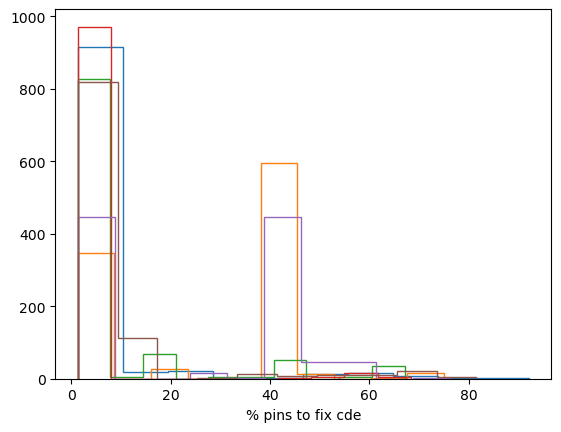

PyObject Text(0.5, 24.0, '% pins to fix cde')

In [50]:
for site in epist_ord[end-5:end]
    plt.hist(abund[site, :], histtype= "step")#color=PyPlot.ColorMap("viridis")(epist_score[site]))
end
plt.xlabel("% pins to fix cde")


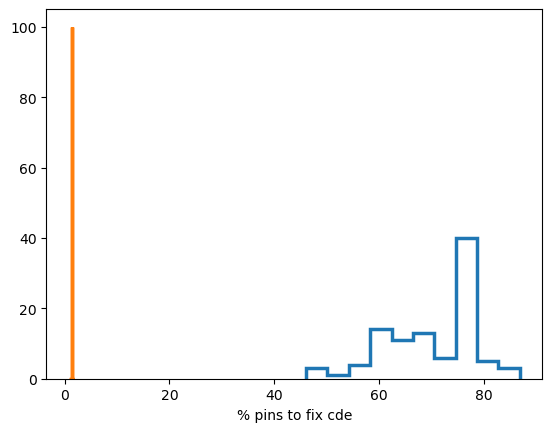

In [66]:
site = 48
n = 100
order = sortperm(chosen_cdes[:,site], rev  = false)[1:n]
plt.hist(abund[site, order], histtype= "step", linewidth = 2.5, label = "low CDE (top 100)")
order = sortperm(chosen_cdes[:,site], rev  = true)[1:n]
plt.hist(abund[site, order], histtype= "step", linewidth = 2.5, label = "high CDE (top 100)")
plt.xlabel("% pins to fix cde")
savefig("../site$(site)_hist_abund.png")

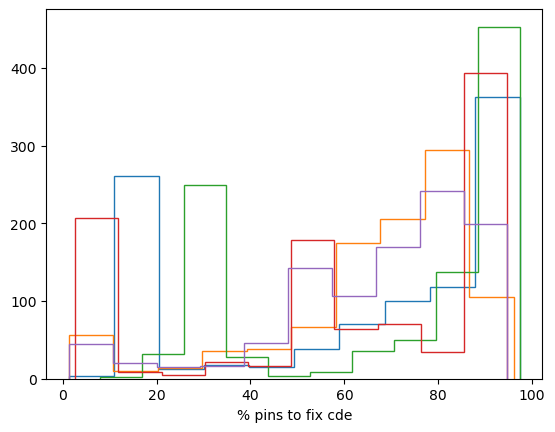

PyObject Text(0.5, 24.0, '% pins to fix cde')

In [51]:
for site in epist_ord[1:5]
    plt.hist(abund[site, :], histtype= "step")
end
plt.xlabel("% pins to fix cde")


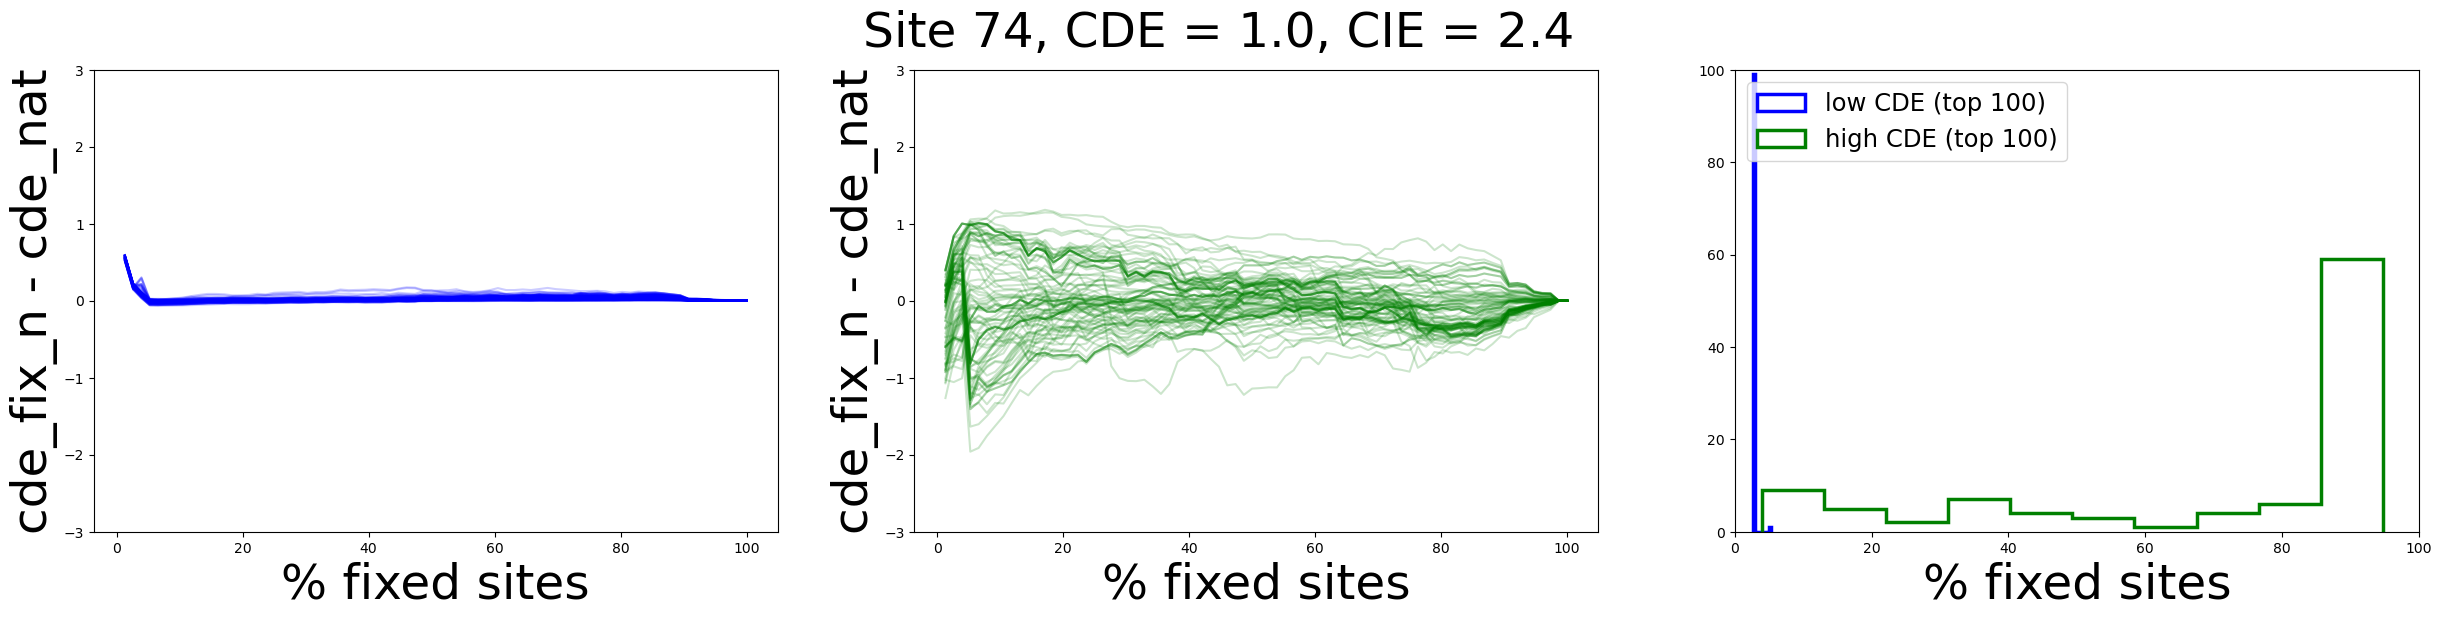

In [115]:
site = 74
n = 100

ticks_font = 25
axis_font = 35

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(6)
fig.set_figwidth(30)
order = sortperm(chosen_cdes[:,site], rev  = false)[1:n]
for s in order
    ax1.plot([i for i in 1:76] .* 100 ./ 76, cde_incr[site, :, s], alpha = 0.2, color = "blue")
end

ax3.hist(abund[site, order], histtype= "step", linewidth = 2.5, color = "blue", 
    label = "low CDE (top 100)")

order = sortperm(chosen_cdes[:,site], rev  = true)[1:n]
for s in order
    ax2.plot([i for i in 1:76] .* 100 ./ 76, cde_incr[site, :, s], alpha = 0.2, color = "green")
end

ax3.hist(abund[site, order], histtype= "step", linewidth = 2.5, 
    label = "high CDE (top 100)", color = "green")

ax1.set_xlabel("% fixed sites", fontsize=axis_font)
ax1.set_ylabel("cde_fix_n - cde_nat", fontsize=axis_font) 
ax1.set_ylim(-3.,3.)

ax2.set_xlabel("% fixed sites", fontsize=axis_font)
ax2.set_ylabel("cde_fix_n - cde_nat", fontsize=axis_font) 
ax2.set_ylim(-3.,3.)

ax3.set_xlabel("% fixed sites",fontsize=axis_font)
ax3.set_xlim(0, 100)
ax3.set_ylim(0, 100)

ax3.legend(loc = "upper left", fontsize = axis_font /2)

fig.suptitle("Site $(site), CDE = $(round(m_cde_nat[site], digits = 1)), CIE = $(round(entr_nat[site], digits = 1))", 
    fontsize=axis_font)

savefig("../site$(site)_lowhigh_cde.png")
